# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Solutions to Homework #6
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 9th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [3]:
import numpy as np
import pandas as pd
from functools import partial
import collections

import time
import math
from functools import partial

%matplotlib inline

## Problem 1: Metropolis and Chill

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you might not recall the correct order, but the mistakes you will tend to make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *Wonder Woman*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *Wonder Woman*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Now, we have a way of quantifying how wrong your answer can be. We define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is the indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* in both answers correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$

### Part A:

Implement an Metropolis algorithm to produce sample guesses from 500 individuals, with various $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

### Part B:
Using the Metropolis algorithm, compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) . Compare the resulting probabilities for the various different $\lambda$ values. Summarize your findings.

**Solutions:**

Gonna use some standard code for MH, with different targets and proposals and what not.

Note that this proposal,
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$
says that the closer (in edit distance) to the correct answer the more likely, more probably, that answer is. So this is a symmetric distribution that peaks at the correct answer.

From the math, you can see right away that $\lambda$ controls the "peakiness" like how concentrated the probability is around the correct answer (like how probable it is that you'd make a super totally wrong guess).


In [4]:
def metropolis(p, q, total_samples, x_init, burn_in):
    samples = []
    x_prev = x_init
    accepted = 0
    
    for i in range(total_samples):
        x_star = q(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdf_ratio = p_star / p_prev
        
        if np.random.uniform() < min(1, pdf_ratio):
            samples.append(x_star)
            x_prev = x_star
            accepted += 1
        else:
            samples.append(x_prev)
            
    return np.array(samples[int(burn_in * total_samples):]), accepted * 1. / len(samples)


In [5]:
#the correct answer
omega = np.array([1, 2, 3, 4, 5])
#proposal distribution
proposal = lambda theta: np.random.permutation(theta)
#Hamming distance from correct answer
d = lambda theta: len((theta - omega)[(theta - omega) != 0])
#target distribution in terms of theta and lambda
target_joint = lambda theta, l: np.e**(-l * d(theta))
#total number of guesses to simulate
total_samples = 500
#initial guess
x_init = np.array([2, 1, 3, 5, 4])

#lambdas to try
lambdas = [0.2, 0.5, 1.0]

#simulate 500 guesses for each lambda value
for l in lambdas:
    target = partial(target_joint, l=l)    
    print('lambda = ', l)
    
    #sample
    samples, accept = metropolis(target, proposal, total_samples, x_init, 0)
    print('accept percent:', accept)
    
    #get top 5 guesses in sample
    samples = [np.array_str(s) for s in samples]    
    vals, counts = np.unique(samples, return_counts=True)
    top_5 = counts.argsort()[-5:][::-1]
    
    print('top 5 guesses:', vals[top_5])
    print('guess frequencies:', counts[top_5])
    print('\n\n')

lambda =  0.2
accept percent: 0.898
top 5 guesses: ['[2 3 4 1 5]' '[2 5 3 1 4]' '[2 5 1 4 3]' '[1 2 3 5 4]' '[5 3 4 2 1]']
guess frequencies: [11 10 10 10  9]



lambda =  0.5
accept percent: 0.724
top 5 guesses: ['[1 2 3 4 5]' '[1 3 2 4 5]' '[5 2 1 4 3]' '[4 2 3 5 1]' '[1 3 5 4 2]']
guess frequencies: [58 19 15 11 10]



lambda =  1.0
accept percent: 0.386
top 5 guesses: ['[1 2 3 4 5]' '[2 1 3 4 5]' '[1 2 4 3 5]' '[1 2 5 4 3]' '[1 3 4 2 5]']
guess frequencies: [75 38 36 35 22]





So the larger the lambda, the more likely you're to guess the right answer and the more tightly you're guesses will cluster around the right answer.

To compute $p(\text{shawshank is top} | lambda)$, we count how many guesses have 1 in the first entry.

In [6]:
for l in lambdas:
    target = partial(target_joint, l=l)
    print('lambda = ', l)
    
    #sample
    samples, accept = metropolis(target, proposal, total_samples, x_init, 0)
    #get top ranked movie for samples
    top_guesses = samples[:, 0]
    
    print('p(shawshank ranked top | lambda)=', len(top_guesses[top_guesses == 1])  * 1. / len(samples))
    print('\n\n')
   

lambda =  0.2
p(shawshank ranked top | lambda)= 0.26



lambda =  0.5
p(shawshank ranked top | lambda)= 0.352



lambda =  1.0
p(shawshank ranked top | lambda)= 0.694





So, $p(\text{shawshank is top} | lambda)$ increases as lambda increases.

## Problem 2: Lensed Galaxies via Metropolis-Hastings

You are a renowned observational astronomer working on gravitational lensing and you just got news about a source whose morphology appears distorted, most likely because there is a foreground source (an ensemble of mini black holes for which you know the mass and position) acting as a lens. Your gravitational lensing calculations indicate that the detected flux $F$ from the background source as a function of right ascencion ($x$) and declination ($y$) can be described by a modified Beale's function:

$F(x,y) = \exp\left[-\left(\frac{x^2}{2\sigma_x^2}+\frac{y^2}{2\sigma_y^2}\right)\right] \log (1.0+(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2) $

with $\sigma_x = \sigma_y = \sqrt{10}$

You are interested in observing this source with the Hubble Space Telescope, and you want to simulate beforehand how photons will form the image on the Hubble detector. You realize that a good way to do this is by sampling F(x,y) with a Monte Carlo method.

### Part A:

Using the following asymmetric function as a proposal distribution:

$q(x,y) = \frac{1}{\sqrt{2 \pi \gamma_1\gamma_2}} {\rm exp}\left[-\left(\frac{(x-0.1)^2}{2 \gamma_1^2} + \frac{(y-0.1)^2}{2 \gamma_2^2}\right) \right] $ 

with $\gamma_1 = 1.0\beta$, $\gamma_2 = 1.5\beta$, and $\beta=1$ (x and y are the coordinates of the proposed step if we center the coordinate system in our current position.)

construct a Metropolis-Hastings algorithm to produce $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.

### Part B:

We want to experiment with $\beta$ by running your code with $\beta$ in the range 0.1 to 40 (think about the appropriate order of magnitude of the $\beta$ spacing). 

1. Plot the accepted sample histories for each $\beta$. What is the acceptance rate for each $\beta$? 
2. Explain your results and select the "best" value of $\beta$?

### Part C:

Choose a symmetric proposal and construct a Metropolis algorithm to product $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.  How do the results compare to those from Metropolis-Hastings in **Parts A & B**?  

**Solutions**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy.stats


from mpl_toolkits import mplot3d

### Define our Lensing Function F(x,y)

In [3]:
## Let's define our function
def F(x,y):
    x = np.array(x)
    x_exp = np.exp(-(x**2 + y**2)/20)
    x_log = np.log(1.0+(1.5 - x+x*y)**2+(2.25-x+x*y**2)**2+(2.625-x+x*y**3)**2)
    return x_exp * x_log

### Visualizing F(x,y)

In [4]:
## Let's setup our mesh
X = np.linspace(-100,100, 2000)
Y = np.linspace(-100,100, 2000)

X,Y = np.meshgrid(X,Y)

In [5]:
## define F
Z=F(X,Y)

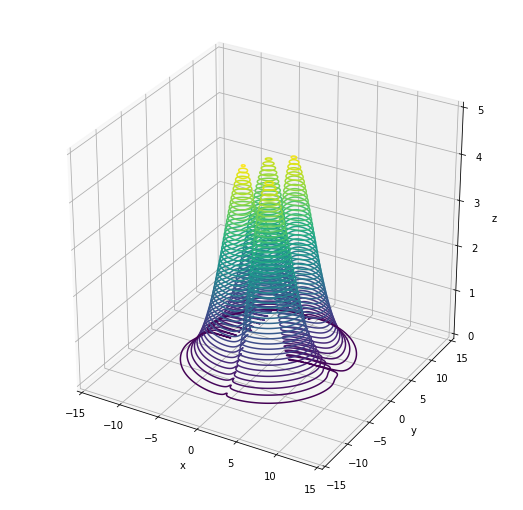

In [6]:
fig = plt.figure(figsize=(9, 9))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim3d(-15, 15)
ax.set_ylim3d(-15, 15)
ax.set_zlim3d(0, 5)

plt.show()

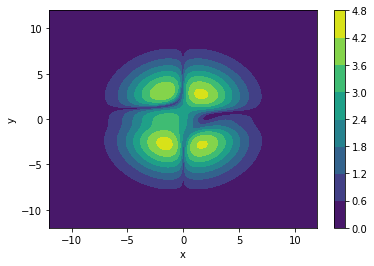

In [7]:
cax = plt.contourf(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')

plt.xlim(-12, 12)
plt.ylim(-12, 12)

plt.colorbar(cax)

So we have a structure with four peaks. The challenge will be to have a proposal step-size that will allow exploration (in particular from one peak to the other) while still staying in the high density region.  Let's define our slightly modified metropolis-hastings from class.

In [8]:
## Let's define our sampling method
def metropolis_hastings(p,q, qdraw, nsamp, xinit):
    
    accepted_count = 0
    samples=np.empty((nsamp,2))
    x_prev = xinit
    for i in tqdm(range(nsamp)):
        x_star = qdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        proposalratio = q(x_prev, x_star)/q(x_star, x_prev)
        if np.random.uniform() < min(1, pdfratio*proposalratio):
            samples[i] = x_star
            x_prev = x_star
            
            # count acceptance
            accepted_count = accepted_count + 1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted_count/nsamp




### Part A:

The proposal density that we're given $q(x,y) = \frac{1}{\sqrt{2 \pi \gamma_1\gamma_2}} {\rm exp}\left[-\left(\frac{(x-0.1)^2}{2 \gamma_1^2} + \frac{(y-0.1)^2}{2 \gamma_2^2}\right) \right] $ 

is a bivariate normal centered around [0.1, 0.1] with covariance [[1.0,0],[0,2.25]]

So we can just use the scipy.stats.


In [9]:
# our covariance matrix
cov = [[1.0, 0], [0, 2.25]]

# our proposal function
qdraw = lambda x: scipy.stats.multivariate_normal.rvs(mean=(0.1, 0.1), cov=cov) + x

# evaluate probability of transition
q = lambda x_new, x_old: scipy.stats.multivariate_normal.pdf(x_new, mean=np.array(x_old)+(0.1, 0.1), cov=cov)

# function that we'll sample from (convenience form)
f = lambda x: F(x[0],x[1])

start = [5, -5]

In [66]:
samples, acceptance = metropolis_hastings(f, q, qdraw, 400000, start)

100%|██████████| 400000/400000 [02:51<00:00, 2336.34it/s]


In [24]:
def plot_path(ax, samples, beta=1.0):
    start = samples[0]
    ax.plot(samples[:,0], samples[:,1], alpha = 0.3)
    ax.scatter(start[0], start[1], c = 'k')
    ax.set_title("Sampling Path for Beta {}".format(beta))

def plot_corr(ax, trace, beta=1.0, label="x", maxlags=50):
    ax.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    ax.set_xlim([0, maxlags])
    ax.set_title("Correlation Plot for {} for Beta {}".format(label, beta))
    
def plot_samples(ax, samples, beta=1.0, bins=80): 
    ax.hist2d(samples[:, 0], samples[:, 1], bins=bins)
    ax.set_xlim([-10, 10])
    ax.set_title("Sampling Histogram for Beta {}".format(beta))
    
def plot_histogram(ax, samples, label = "x", beta=1.0, bins=80): 
    ax.hist(samples, bins=bins, histtype="step", density=True, color="darkblue")
    ax.set_title("Sampling Histogram for {} for Beta {}".format(label, beta))
    ax.set_ylabel(label)

def plot_traceplot(ax, samples, beta=1.0, label = "x", bins=80): 
    ax.plot(samples, alpha=0.3)
    ax.set_title("Traceplot for {} for Beta {}".format(label, beta))
    ax.set_ylabel(label)

In [56]:
def visualize_beta(samples, acceptance, beta=1):
    
    plt.suptitle("Beta: {:}\nAcceptance rate: {}".format(beta, acceptance))
    plot_path(ax[0,0], samples, beta=beta)
    plot_samples(ax[0,1], samples, beta=beta)
    plot_histogram(ax[1,0], samples[:,0], label='x', beta=beta)
    plot_traceplot(ax[1,1], samples[:,0], label='x', beta=beta)
    plot_histogram(ax[2,0], samples[:,1], label='y', beta=beta)
    plot_traceplot(ax[2,1], samples[:,1], label='y', beta=beta)
    plot_corr(ax[3,0], samples[:,0], label='x', beta=beta)
    plot_corr(ax[3,1], samples[:,1], label='y', beta=beta)

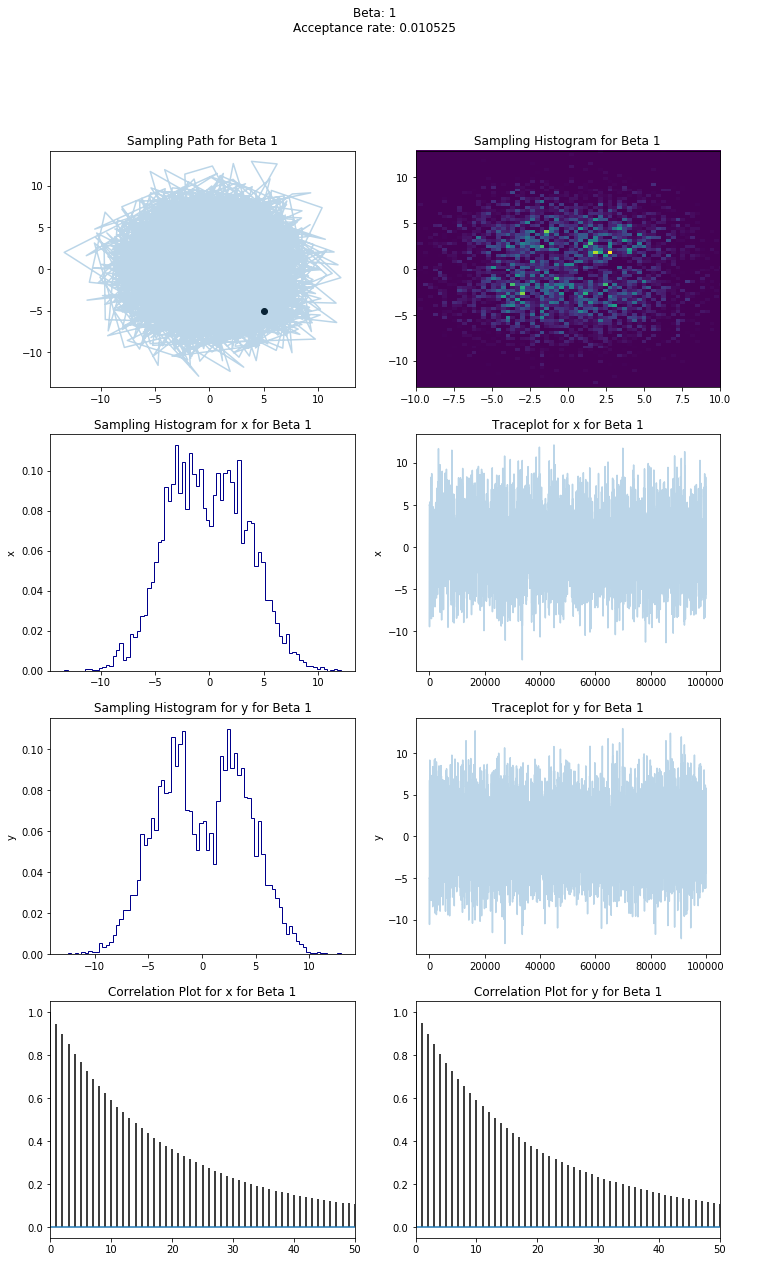

In [72]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
old_samples = samples.copy()
samples = old_samples[::4]

visualize_beta(samples, acceptance)

As you can see from the visualizations we're doing a reasonable job of sampling the region of interest.  Our starting place is in our region of interest, so burnin isn't necessary.  Although our traceplots look ok, we have quite of bit of correlation which thinning does a bit to resolve -- an indication that our stepsize should be somewhat larger.  Our high acceptance rate is another indication that we could do a better job of tuning the stepsize of our proposal distribution.  Regardless we get clear (and accurate) samples of the the marginals as shown by the sampling histograms. To get a better view of what's going on, let's look more closely at the traceplot.

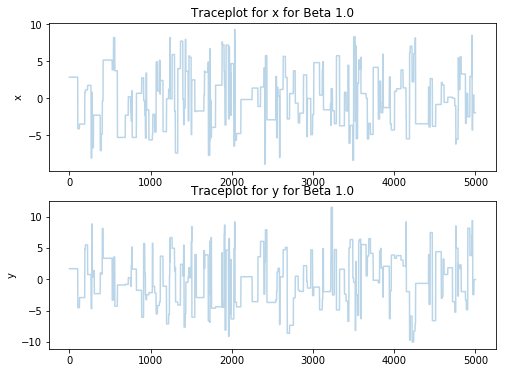

In [73]:
fig, ax = plt.subplots(2,1, figsize=(8,6))

plot_traceplot(ax[0], samples[10000:15000,0], label="x")
plot_traceplot(ax[1], samples[10000:15000,1], label="y")


As expected, zooming in on the traceplot shows the structure that we already know is there from the correlation plots.  Onward to experimenting with more betas.

### Part B:

We'll look at how varying beta affects sampling by looking at the following values of beta: [0.1, 5, 15, 25, 40].  We'll skip thinning to better see the betas impact on sampling characteristics.

In [50]:
sample_tuples = []
cov = [[1.0, 0], [0, 2.25]]
betas = [0.1, 2, 4, 15, 25, 40]

for beta in betas:
    
    ## New covariance 
    cov_candidate = [[beta**2, 0], [0, 2.25*beta**2]]
    
    # new proposal function
    qdraw = lambda x: scipy.stats.multivariate_normal.rvs(mean=(0.1, 0.1), cov=cov_candidate) + x

    # evaluate probability of transition
    q = lambda x_new, x_old: scipy.stats.multivariate_normal.pdf(x_new, mean=np.array(x_old)+(0.1, 0.1), cov=cov_candidate)

    sample_tuples.append(metropolis_hastings(f, q, qdraw, 100000, start))

100%|██████████| 100000/100000 [00:42<00:00, 2346.11it/s]


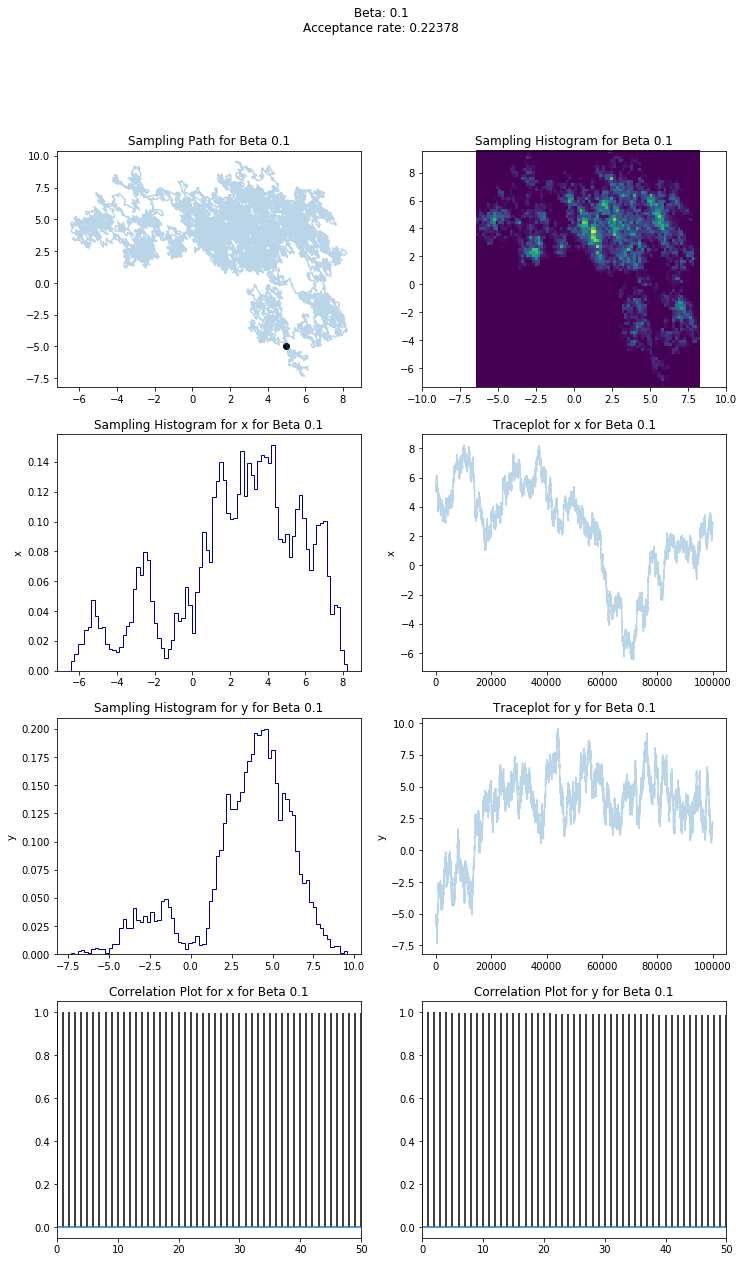

In [60]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(sample_tuples[0][0], sample_tuples[0][1], beta=betas[0])

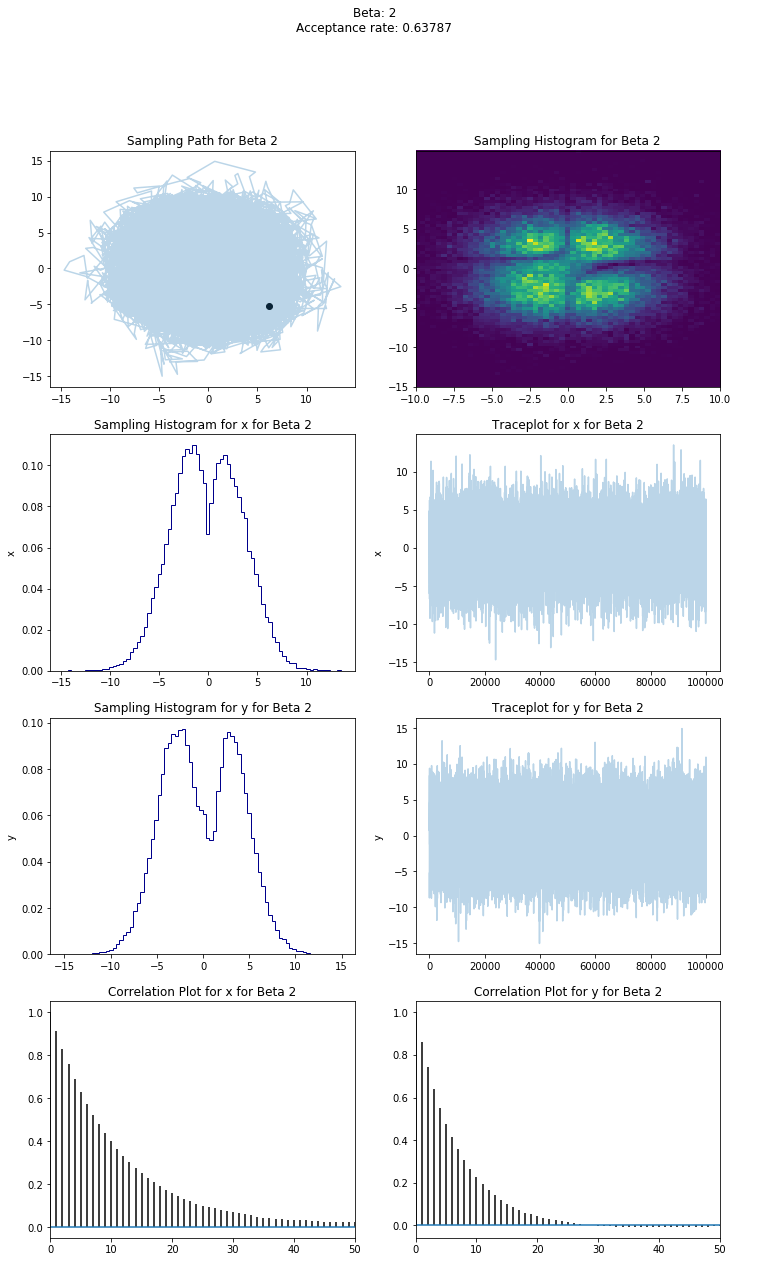

In [61]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(sample_tuples[1][0], sample_tuples[1][1], beta=betas[1])

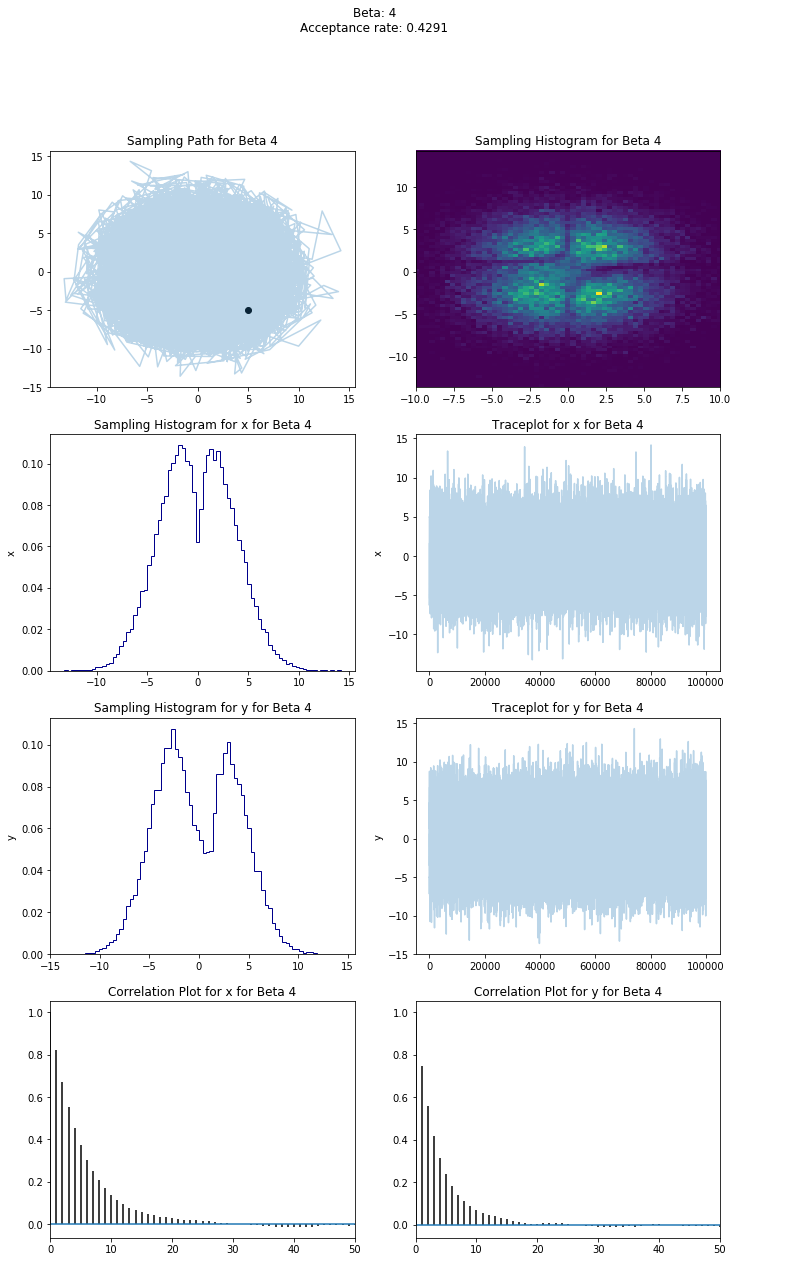

In [62]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(sample_tuples[2][0], sample_tuples[2][1], beta=betas[2])

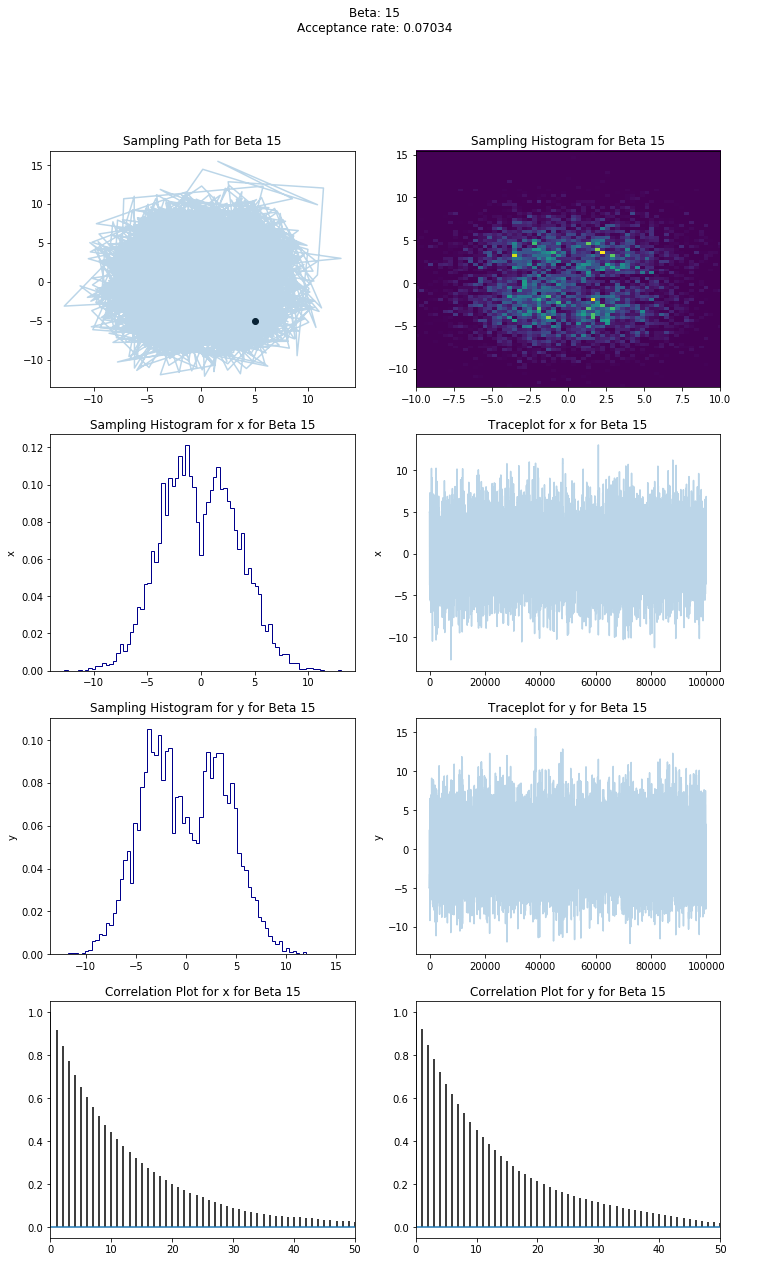

In [63]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(sample_tuples[3][0], sample_tuples[3][1], beta=betas[3])

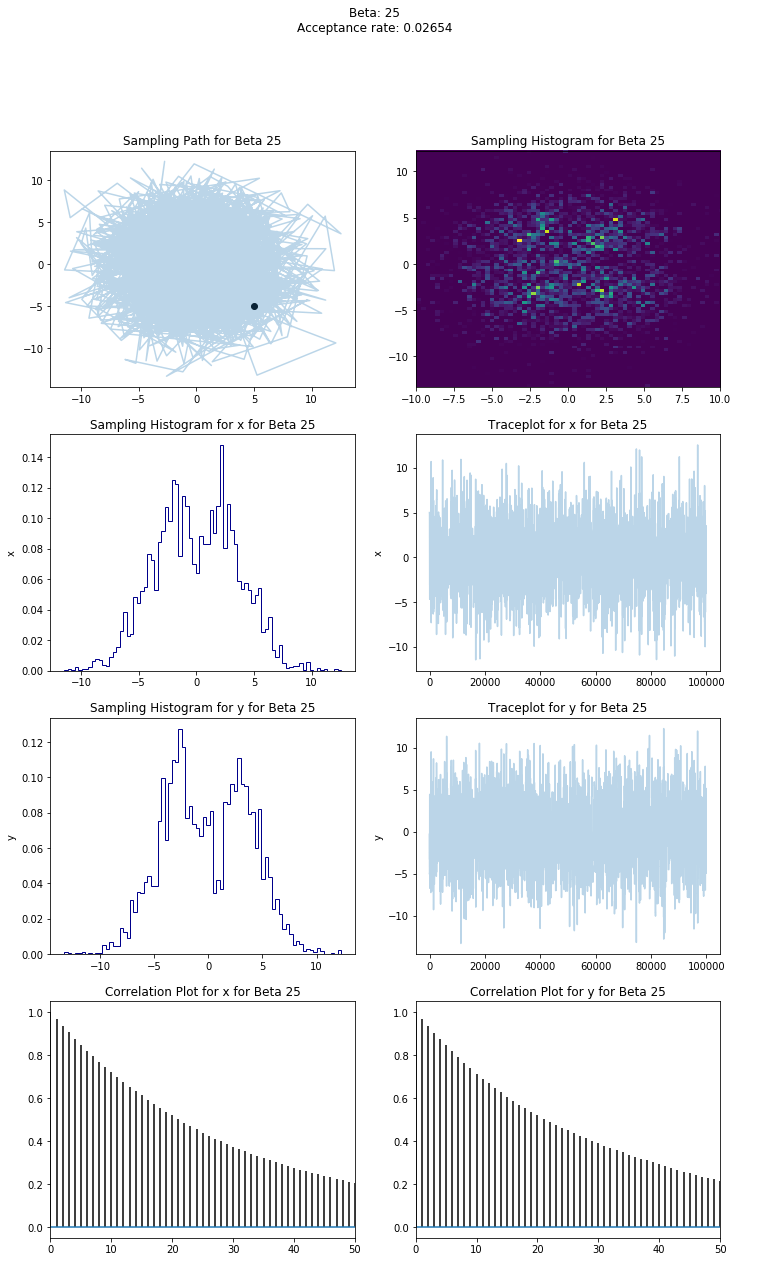

In [64]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(sample_tuples[4][0], sample_tuples[4][1], beta=betas[4])

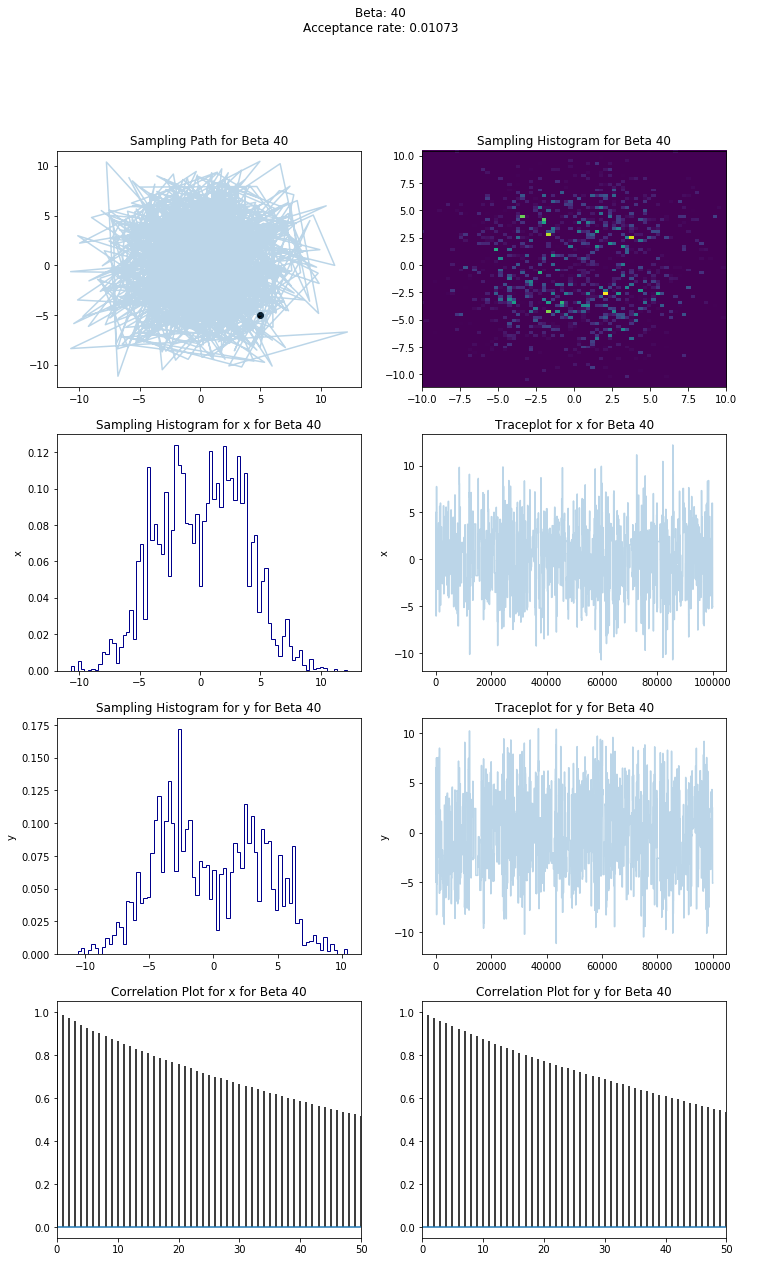

In [65]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(sample_tuples[5][0], sample_tuples[5][1], beta=betas[5])

Beta == 4 is clearly the best choice.  For betas < 4, we see high degrees of correlation (beta = 0.1 being the extreme case) and for betas > 4 we see that the step-size is too large and high degrees of autocorrelation because of too man rejected samples (beta= 25, 40 being the extreme cases).  Beta == 4 is the only beta in the acceptable range.

Let's for kicks experiment with one more value of beta (beta == 5) to see if we get a more optimized step-size.

In [67]:
betas.append(5)

## New covariance 
cov_candidate = [[betas[6]**2, 0], [0, 2.25*betas[6]**2]]

# new proposal function
qdraw = lambda x: scipy.stats.multivariate_normal.rvs(mean=(0.1, 0.1), cov=cov_candidate) + x

# evaluate probability of transition
q = lambda x_new, x_old: scipy.stats.multivariate_normal.pdf(x_new, mean=np.array(x_old)+(0.1, 0.1), cov=cov_candidate)

sample_tuples.append(metropolis_hastings(f, q, qdraw, 100000, start))

100%|██████████| 100000/100000 [00:41<00:00, 2406.37it/s]


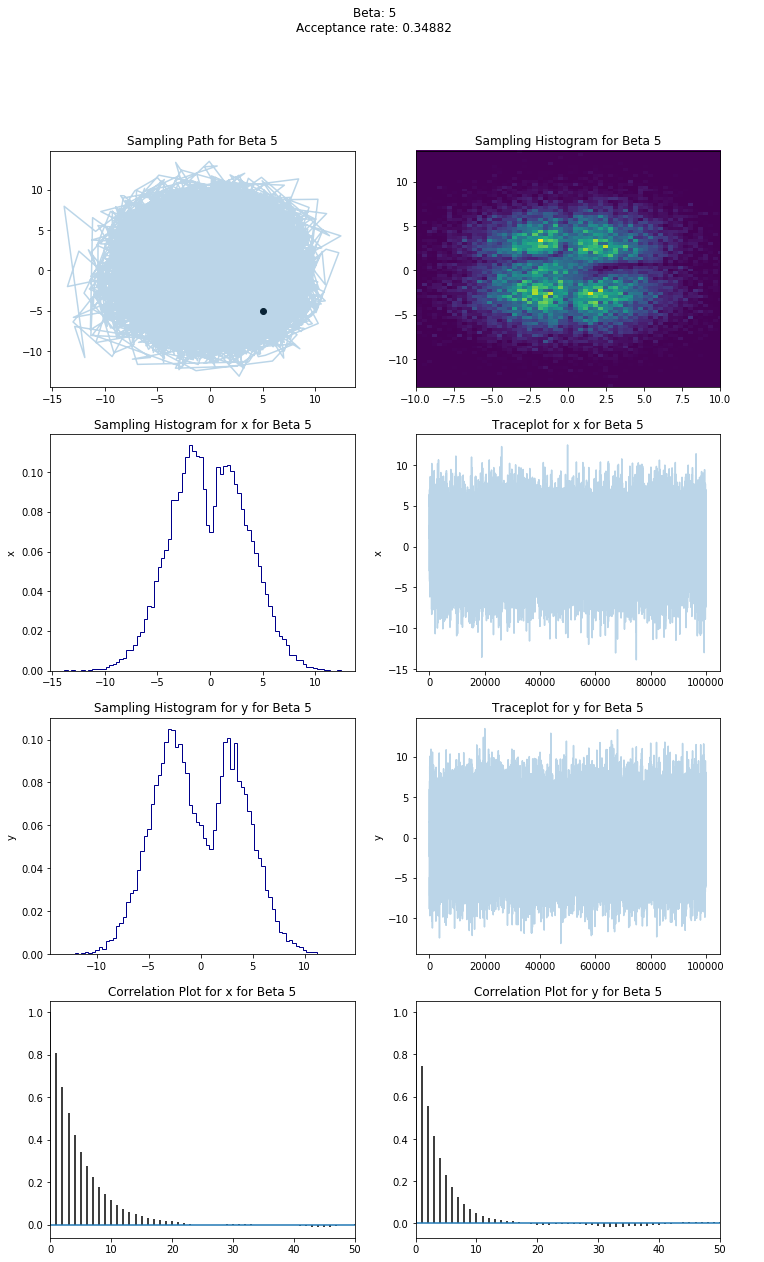

In [71]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(sample_tuples[6][0], sample_tuples[6][1], beta=betas[6])

Great acceptance rate, nice correlation plots, nice histograms.  Looks like we found our winner!

### Part C:

The asymmetry in our original proposal comes from the non-centered gaussian that we used.  If we use a gaussian proposal centered at the current sample, then we can use a metropolis algorithm to sample.

In [74]:
## Let's define our sampling method
def metropolis(p, pdraw, nsamp, xinit):
    
    accepted_count = 0
    samples=np.empty((nsamp,2))
    x_prev = xinit
    for i in tqdm(range(nsamp)):
        x_star = pdraw(x_prev)
        p_star = p(x_star)
        p_prev = p(x_prev)
        pdfratio = p_star/p_prev
        if np.random.uniform() < min(1, pdfratio):
            samples[i] = x_star
            x_prev = x_star
            
            # count acceptance
            accepted_count = accepted_count + 1
        else:#we always get a sample
            samples[i]= x_prev
            
    return samples, accepted_count/nsamp


In [77]:
metropolis_tuples = []
cov = [[1.0, 0], [0, 2.25]]
betas = [0.1, 5, 15, 25]

for beta in betas:
    
    ## New covariance 
    cov_candidate = [[beta**2, 0], [0, 2.25*beta**2]]
    
    # new proposal function
    pdraw = lambda x: scipy.stats.multivariate_normal.rvs(cov=cov_candidate) + x

    metropolis_tuples.append(metropolis(f, pdraw, 100000, start))

100%|██████████| 100000/100000 [00:17<00:00, 5721.89it/s]


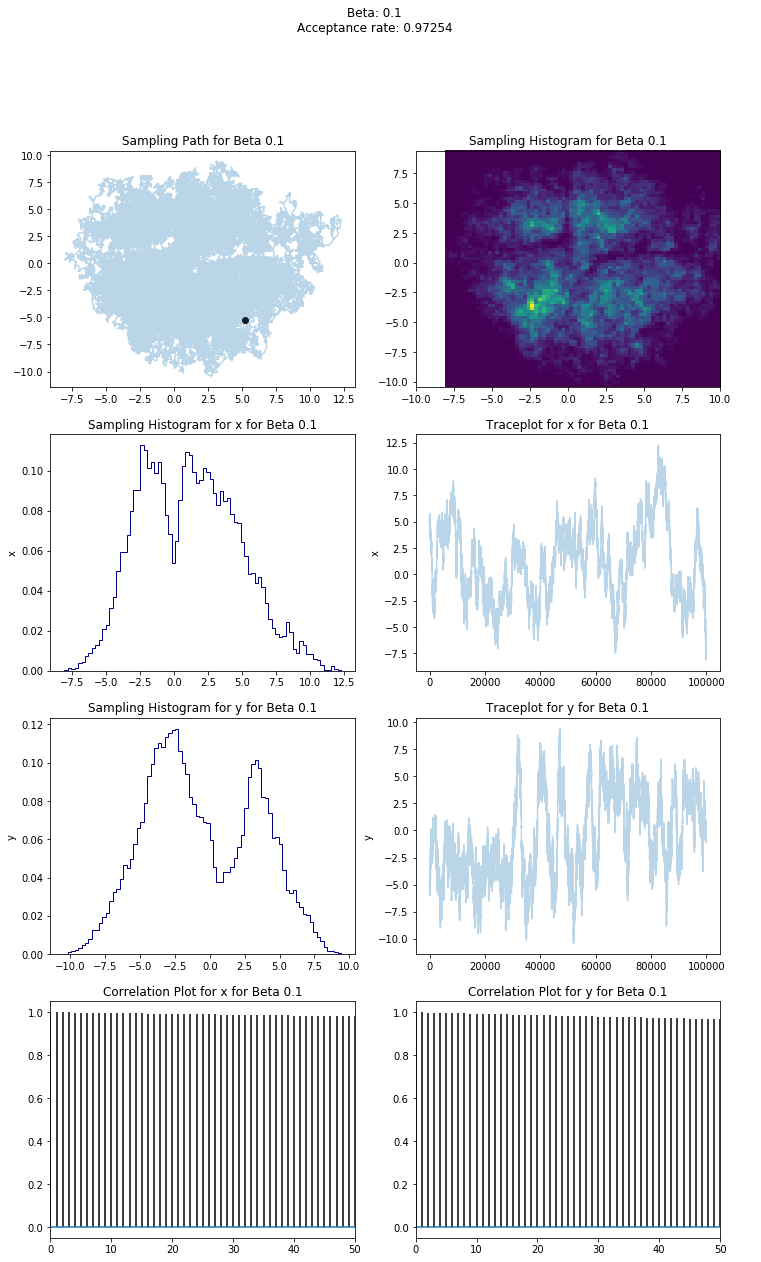

In [78]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(metropolis_tuples[0][0], metropolis_tuples[0][1], beta=betas[0])

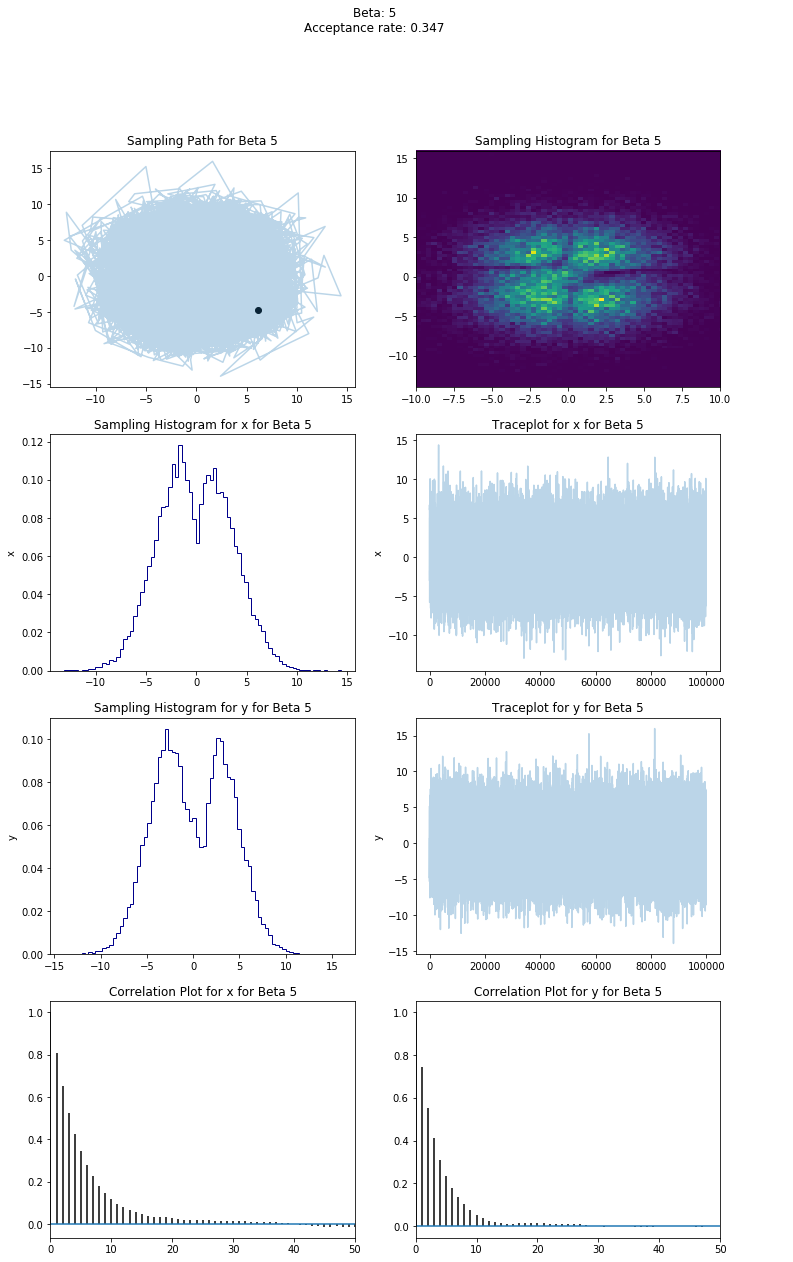

In [79]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(metropolis_tuples[1][0], metropolis_tuples[1][1], beta=betas[1])

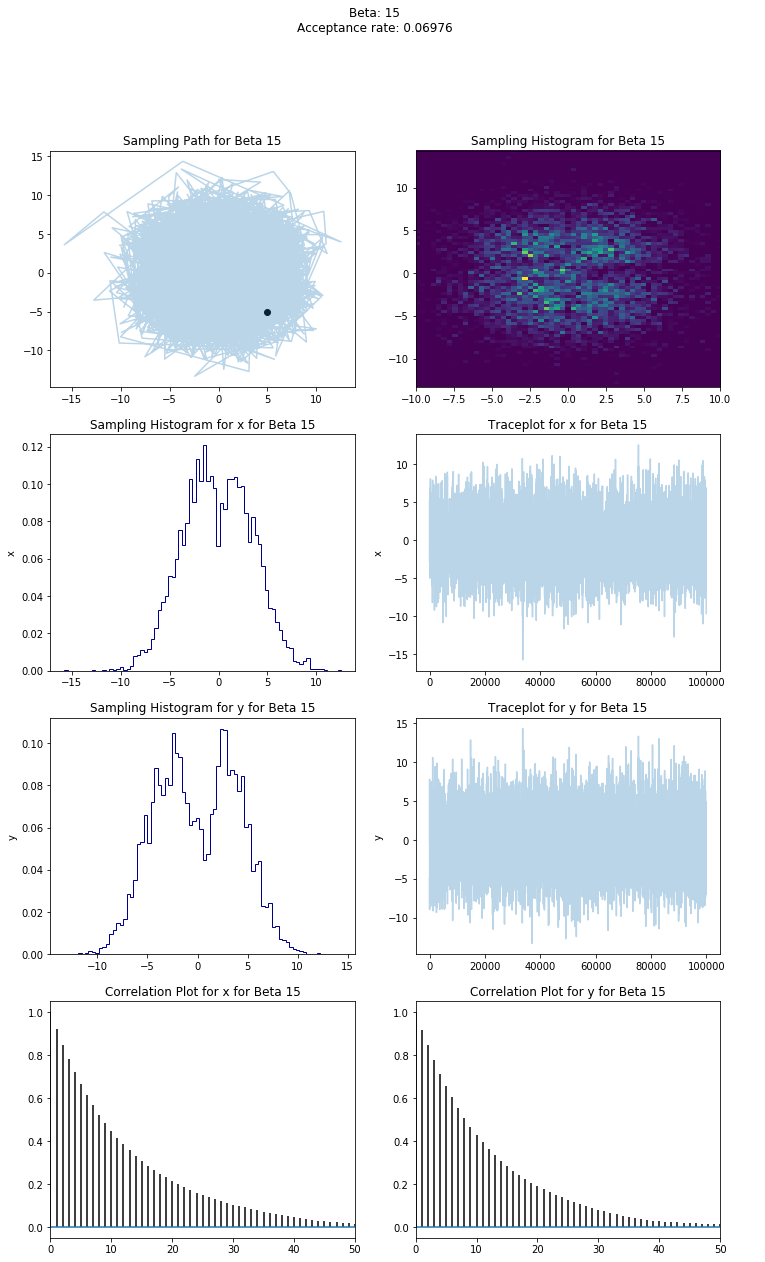

In [80]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(metropolis_tuples[2][0], metropolis_tuples[2][1], beta=betas[2])

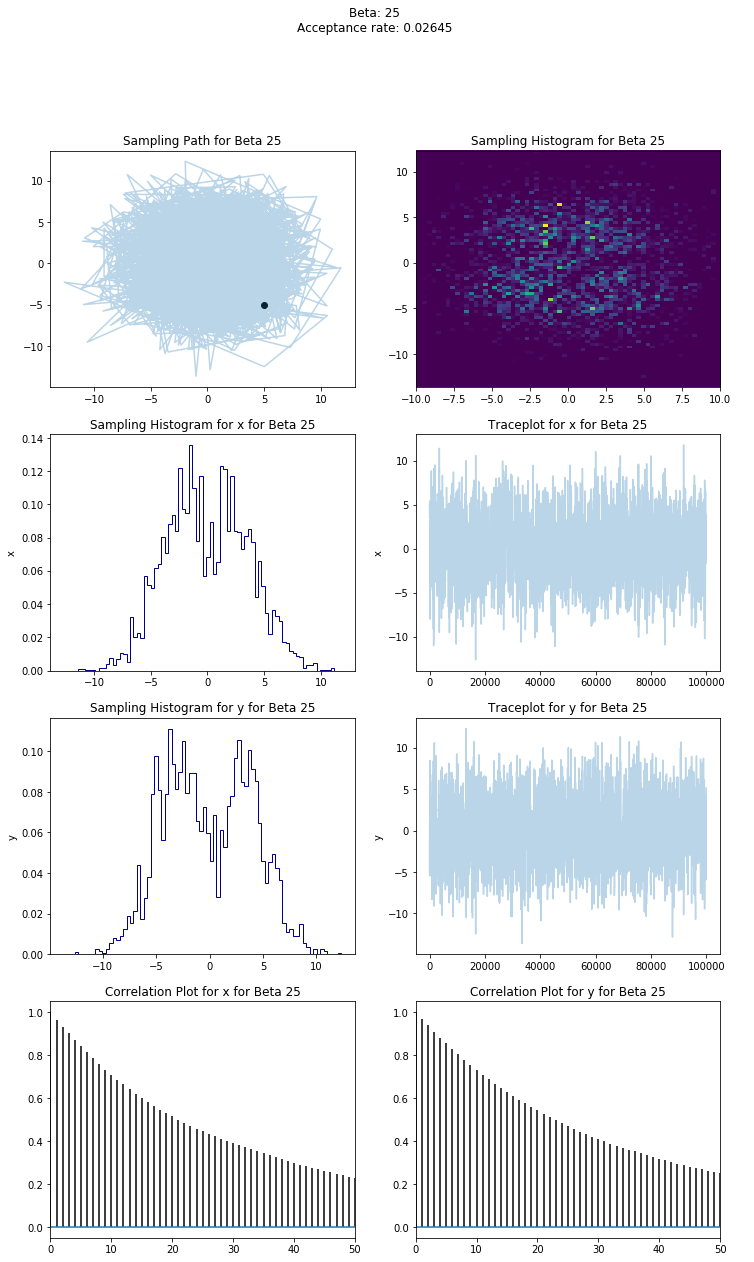

In [81]:
fig, ax = plt.subplots(4,2,figsize=(12,20))
visualize_beta(metropolis_tuples[3][0], metropolis_tuples[3][1], beta=betas[3])

For beta == 0.1 the metropolis algorithm did a noticeably better job.  For the other beta values, the results were approximately the same with the tiny edge if any going to the metropolis-hastings algorithm.